In [135]:
%%capture
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from numpy import linalg
import math
import statistics 
import random
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
!pip install category_encoders==2.*
df = pd.read_csv('https://raw.githubusercontent.com/SophistryDude/Unit-2-Build-week/main/games.csv')
print(df.shape)
df.info()

#Data Wrangling

This dataset was taken from the popular chess website, Lichess. It holds information on the players, as well as metadata such as opening name. I would like to look at a few targets:
1. The amount of turns it takes to win, using the time increment and disparity in player ratings as feature engineers. 
2. the type of game based on ratings
3. the win rate of ratings

For this I'm going to separate my data a bit, and also create some new features. 

In [136]:
#I'll store my move list just in case, but I doubt i will use it. I may use the openings later to present my data to potential clients. 
original = df.copy()
moves = {'ID':original['id'], 'Moves':original['moves']}
opening = {'opening_eco':original['opening_eco'], 'Opening_name':original['opening_name']}
df = df.drop(columns=['id', 'rated', 'created_at', 'last_move_at', 'victory_status', 'white_id', 'black_id', 'moves', 'opening_ply','opening_name'])
print(df.shape)
df.head()


(20058, 6)


,turns,winner,increment_code,white_rating,black_rating,opening_eco
0,13,white,15+2,1500,1191,D10
1,16,black,5+10,1322,1261,B00
2,61,white,5+10,1496,1500,C20
3,61,white,20+0,1439,1454,D02
4,95,white,30+3,1523,1469,C41


In [137]:
# as shown above, there are approximely 20,000 games in this database, let's get some initial analysis of the data
df.groupby('winner').size()


winner
black     9107
draw       950
white    10001
dtype: int64

In [138]:
# Our winner category has 3 entries, in order to analyze the opening success rates we need to wrangle our data a little bit more. I'm going make a separate DF to assess 
#the success rate of each opening.
df2 = df.copy()
df2['White Wins'], df2['Black Wins'], df2['Draw'] = (df2['winner'] == 'white'), (df2['winner'] == 'black'), (df2['winner'] == 'draw')
df2[['White Wins']], df2[['Black Wins']], df2['Draw'] = df2[['White Wins']].astype(int), df2['Black Wins'].astype(int), df2['Draw'].astype(int)
df2.head()


,turns,winner,increment_code,white_rating,black_rating,opening_eco,White Wins,Black Wins,Draw
0,13,white,15+2,1500,1191,D10,1,0,0
1,16,black,5+10,1322,1261,B00,0,1,0
2,61,white,5+10,1496,1500,C20,1,0,0
3,61,white,20+0,1439,1454,D02,1,0,0
4,95,white,30+3,1523,1469,C41,1,0,0


In [139]:
#Now we go back to a DF with our openings set as the index, and 4 new features. Additionally, this dataframe is now sorted by most popular 
info = df2.groupby(['opening_eco']).sum()
info = info.drop(columns=['white_rating', 'black_rating', 'turns'])
info['TGP'] = info['White Wins'] + info['Black Wins'] + info['Draw']
info = info.sort_values(by=['TGP'], ascending=False)
info.head()

,White Wins,Black Wins,Draw,TGP
opening_eco,,,,
A00,398,570,39,1007
C00,417,389,38,844
D00,341,360,38,739
B01,358,332,26,716
C41,396,267,28,691


In [140]:
# in order to test for things such as variance on each opening, we need to convert the games played in aggregate to a percentage of games with noted outcome. 
stat = info.copy()
stat['White Wins'] = info['White Wins'] / info['TGP']
stat['Black Wins'] = info['Black Wins'] / info['TGP']
stat['Draw'] = info['Draw'] / info['TGP']

stat.head()

,White Wins,Black Wins,Draw,TGP
opening_eco,,,,
A00,0.395233,0.566038,0.038729,1007
C00,0.494076,0.460900,0.045024,844
D00,0.461434,0.487145,0.051421,739
B01,0.500000,0.463687,0.036313,716
C41,0.573082,0.386397,0.040521,691


#Putting the name back

Because the naming scheme for chess moves has such a high cardinality rate, I'm not going to use them in the dataframe for my models. That being said, it is nice to know what the codes actually refer to. 

In [141]:
names = pd.DataFrame(opening)
names = names.groupby(['opening_eco']).sum()
names.head()

,Opening_name
opening_eco,
A00,Van't Kruijs OpeningCrab OpeningHungarian Open...
A01,Nimzo-Larsen Attack: Modern VariationNimzo-Lar...
A02,Bird OpeningBird OpeningBird OpeningBird Openi...
A03,Bird OpeningBird Opening: Dutch VariationBird ...
A04,Zukertort Opening: Ross GambitZukertort Openin...


In [142]:
names = pd.merge(names, info, on='opening_eco', how='inner')
names.head()

,Opening_name,White Wins,Black Wins,Draw,TGP
opening_eco,,,,,
A00,Van't Kruijs OpeningCrab OpeningHungarian Open...,398,570,39,1007
A01,Nimzo-Larsen Attack: Modern VariationNimzo-Lar...,76,80,8,164
A02,Bird OpeningBird OpeningBird OpeningBird Openi...,32,45,5,82
A03,Bird OpeningBird Opening: Dutch VariationBird ...,30,38,10,78
A04,Zukertort Opening: Ross GambitZukertort Openin...,156,101,28,285


In [143]:
names = names.groupby(['opening_eco']).sum()
names['TGP'] = names['White Wins'] + names['Black Wins'] + names['Draw']
names= names.sort_values(by=['TGP'], ascending=False)
names.head()

,White Wins,Black Wins,Draw,TGP
opening_eco,,,,
A00,398,570,39,1007
C00,417,389,38,844
D00,341,360,38,739
B01,358,332,26,716
C41,396,267,28,691


#Variance experiment

In [144]:
variance_info = info.copy()
mean_white = variance_info['White Wins'].mean()
mean_black = variance_info['Black Wins'].mean()
mean_draw = variance_info['Draw'].mean()
variance_info['WWRVar'] = variance_info['White Wins'] - mean_white
variance_info['BWRVar'] = variance_info['Black Wins'] - mean_black
variance_info['DRVar'] = variance_info['Draw'] - mean_draw
white_std_dev = np.std(variance_info['White Wins'], ddof=1)
black_std_dev = np.std(variance_info['Black Wins'], ddof=1)
print('Mean WWR:', mean_white)
print('Mean BWR:', mean_black)
print('Mean Draw:', mean_draw)
print('WWRVar:', variance_info['White Wins'].var())
print('BWRVar:', variance_info['Black Wins'].var())
print('DrawVar:', variance_info['Draw'].var())
print('White std dev:', white_std_dev)
print('Black std dev:', black_std_dev)
variance_info.head()

Mean WWR: 27.4
Mean BWR: 24.95068493150685
Mean Draw: 2.6027397260273974
WWRVar: 4050.2461538461553
BWRVar: 3799.014044859233
DrawVar: 32.65219027547816
White std dev: 63.64154424466895
Black std dev: 61.6361423586781


,White Wins,Black Wins,Draw,TGP,WWRVar,BWRVar,DRVar
opening_eco,,,,,,,
A00,398,570,39,1007,370.6,545.049315,36.39726
C00,417,389,38,844,389.6,364.049315,35.39726
D00,341,360,38,739,313.6,335.049315,35.39726
B01,358,332,26,716,330.6,307.049315,23.39726
C41,396,267,28,691,368.6,242.049315,25.39726


In [145]:
observations = len(info)
white_obs = variance_info['WWRVar']**2
white_obs = white_obs.sum()/(observations-1)
black_obs = variance_info['BWRVar']**2
black_obs = black_obs.sum()/(observations-1)
print('W:', white_obs)
print('B:', black_obs)

W: 4050.246153846154
B: 3799.014044859251


#Rating bins

In [146]:
df2['white_rating'].describe()

count    20058.000000
mean      1596.631868
std        291.253376
min        784.000000
25%       1398.000000
50%       1567.000000
75%       1793.000000
max       2700.000000
Name: white_rating, dtype: float64

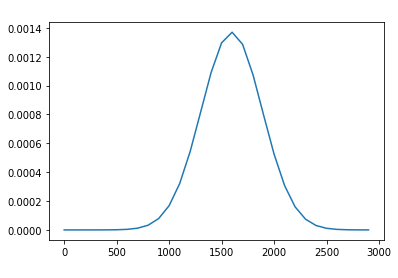

In [147]:
import scipy.stats
mean = 1596.631868
std = 291.253376
x_values = np.arange(0, 3000, 100)
y_values = scipy.stats.norm(mean, std)
plt.plot(x_values, y_values.pdf(x_values))
plt.title('Player Distribution Curve', color='white')
plt.xlabel('Rating level', color='white')
plt.show()

In [148]:
ranking = df2.copy()
cut_troll_labels = ['Wood_5', 'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'CM', 'FM', 'IM', 'GM', 'Super GM']
cut_bins = [0, 800, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 4000]
ranking['ranking'] = pd.cut(ranking['white_rating'], bins=cut_bins, labels=cut_troll_labels)

In [149]:
ranking.head()

,turns,winner,increment_code,white_rating,black_rating,opening_eco,White Wins,Black Wins,Draw,ranking
0,13,white,15+2,1500,1191,D10,1,0,0,Gold
1,16,black,5+10,1322,1261,B00,0,1,0,Silver
2,61,white,5+10,1496,1500,C20,1,0,0,Gold
3,61,white,20+0,1439,1454,D02,1,0,0,Gold
4,95,white,30+3,1523,1469,C41,1,0,0,Gold


#Split Data

There are a few targets we're going to look at: 
1. Game length (turns)
2. Black Wins Over 50%
3. White Wins over 50%
4. Ranking

In [150]:
# Glength = 'turns'
# Bwins = 'Black Wins'
# Wwins = 'White Wins'
# rankings = 'ranking'

# f_Glength = ranking[Glength]
# X_Glength = ranking.drop(['turns'], axis=1)
# f_Bwins = stat[Bwins]
# X_Bwins = stat.drop(columns=Bwins)
# f_Wwins = stat[Wwins]
# X_Wwins = stat.drop(columns=Wwins)
# f_ranking = ranking[rankings]
# X_ranking = ranking.drop(columns=ranking)

# print(f_Glength.shape)
# print(X_Glength.shape)

target = 'turns'
y = ranking[target]
X = ranking.drop(columns=target)
print(y.shape)
print(X.shape)

(20058,)
(20058, 9)


In [151]:
from sklearn.model_selection import train_test_split

X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)


(16046, 9)
(4012, 9)


In [152]:
from sklearn.metrics import mean_absolute_error

baseline_acc = y_train.value_counts(normalize=True).max()
y_pred = [y.mean()]*len(y)
print('Baseline Acc:', baseline_acc)

Baseline Acc: 0.01570484856038888


Our baseline accuracy is pretty abysmal, but the thing we are measuring is the length of games, which isn't truly determinant by any factor. The hypothesis is our length of games will increase based on the rating of players. Our second hypothesis relating to game length is going to be based on disparity between the player ratings. 

In [153]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer

model_lin = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LinearRegression())
model_lin.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['winner', 'increment_code', 'opening_eco',
                                     'ranking'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [154]:
print('Train ACC Score:', model_lin.score(X_train, y_train))
print('Validation ACC Score:', model_lin.score(X_val, y_val))

Train ACC Score: 0.11728994085049314
Validation ACC Score: -1.81151070583888e+23


Text(0, 0.5, 'Length of game')

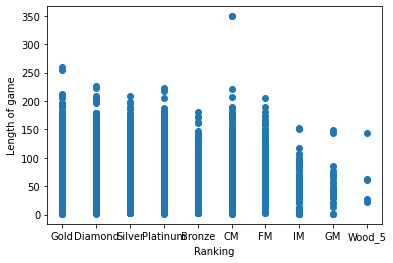

In [155]:
plt.scatter(X_train['ranking'], y_train)
# chart = sns.scatterplot(data=ranking, x='ranking', y='turns')
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.xlabel('Ranking')
plt.ylabel('Length of game')
#plt.xticks(X_train['ranking'], cut_troll_labels, rotation=45);

Looking at this data, it seems that the highest concentration of long games are actually in the middle rankings {Gold, Diamond, Platinum, CM}. 

In [156]:
model_log = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression())
model_log.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [157]:
print('Training Acc Score:', model_log.score(X_train, y_train))
print('Validation ACC Score:', model_log.score(X_val, y_val))

Training Acc Score: 0.2032282188707466
Validation ACC Score: 0.03589232303090728


Using a linear model, we started to see significance in our scoring, although still within 1 std deviation. While using the logistic model we went up to a 20% accuracy score, which means that there are features that have bearing on the target (game length). Our validation accuracy is really low, which tells me that our findings aren't worth very much yet. 


Based on this information, it seems appropriate to engineer a new feature, disparity in player rating. 





In [158]:
ranking.head()

,turns,winner,increment_code,white_rating,black_rating,opening_eco,White Wins,Black Wins,Draw,ranking
0,13,white,15+2,1500,1191,D10,1,0,0,Gold
1,16,black,5+10,1322,1261,B00,0,1,0,Silver
2,61,white,5+10,1496,1500,C20,1,0,0,Gold
3,61,white,20+0,1439,1454,D02,1,0,0,Gold
4,95,white,30+3,1523,1469,C41,1,0,0,Gold


In [159]:
ranking['Disparity'] = abs(ranking['white_rating']-ranking['black_rating'])
ranking.head()

,turns,winner,increment_code,white_rating,black_rating,opening_eco,White Wins,Black Wins,Draw,ranking,Disparity
0,13,white,15+2,1500,1191,D10,1,0,0,Gold,309
1,16,black,5+10,1322,1261,B00,0,1,0,Silver,61
2,61,white,5+10,1496,1500,C20,1,0,0,Gold,4
3,61,white,20+0,1439,1454,D02,1,0,0,Gold,15
4,95,white,30+3,1523,1469,C41,1,0,0,Gold,54


In [160]:
XR = ranking.drop(columns=target)
XR_train , XR_val, yr_train, yr_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(XR_train.shape)
print(XR_val.shape)

print(y.shape)
print(XR.shape)

(16046, 9)
(4012, 9)
(20058,)
(20058, 10)


In [161]:
model_log = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression())
model_log.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [162]:
print('Training Acc Score:', model_log.score(X_train, y_train))
print('Validation ACC Score:', model_log.score(X_val, y_val))

Training Acc Score: 0.2032282188707466
Validation ACC Score: 0.03589232303090728


In [163]:
y_pred = [y.mean()]* len(y)
print('Expected variation in moves:', mean_absolute_error(y, y_pred))
print('Average number of moves:', y.mean())
print('Maximum number of moves:', y.max())
print('Minium number of moves:', y.min())

Expected variation in moves: 26.119823918553237
Average number of moves: 60.46599860404826
Maximum number of moves: 349
Minium number of moves: 1


In [164]:
x = ranking[['Disparity']]
y = ranking[target]
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)

In [165]:
print(mean_absolute_error(y, y_pred))

25.925188711477244


No handles with labels found to put in legend.


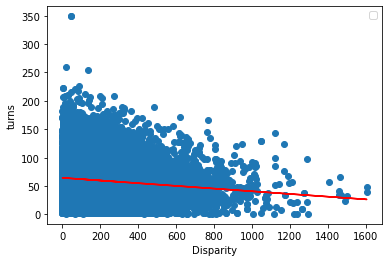

In [166]:
plt.scatter(x,y)
plt.plot(x,y_pred, color='r')
plt.xlabel('Disparity')
plt.ylabel('turns')
plt.legend()

In [181]:
print(f'Turns = {model.intercept_} + {model.coef_[0]} x Disparity')

Turns = 64.56857718633168 + -0.023701800069426862 x Disparity


The length of games is somewhat surprising, but the conclusion is expected. As the disparity between player level increases, the amount of moves necessary for a player to win decreases. The rate of decrease is fairly slow, which may show how steep the learning curve is. In many games a disparity of 200 rating means that the lower level player is beaten very hard, very quickly.

#Tree models

In [168]:
ranking.head()

,turns,winner,increment_code,white_rating,black_rating,opening_eco,White Wins,Black Wins,Draw,ranking,Disparity
0,13,white,15+2,1500,1191,D10,1,0,0,Gold,309
1,16,black,5+10,1322,1261,B00,0,1,0,Silver,61
2,61,white,5+10,1496,1500,C20,1,0,0,Gold,4
3,61,white,20+0,1439,1454,D02,1,0,0,Gold,15
4,95,white,30+3,1523,1469,C41,1,0,0,Gold,54


In [169]:
target = 'ranking'
leaky_col = 'white_rating'
y = ranking[target]
X = ranking.drop(columns=[target, leaky_col])
print(y.shape)
print(X.shape)

(20058,)
(20058, 9)


# Split

In [170]:
X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)

(16046, 9)
(4012, 9)


In [171]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline ACC:', baseline_acc)

Baseline ACC: 0.288607752710956


#Model_bag


In [172]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1))
model_bag.fit(X_train, y_train);
model_bag.fit(X_val, y_val);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [173]:
print('Train ACC:', model_bag.score(X_train, y_train))
print('Val ACC:', model_bag.score(X_val, y_val))

Train ACC: 0.7164402343263119
Val ACC: 1.0


#Model_boost

In [174]:
from xgboost import XGBClassifier
model_boost = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(max_depth=10))
model_boost.fit(X_train, y_train);
model_boost.fit(X_val, y_val);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [182]:
print('RandomForest Classifier Training ACC:', model_bag.score(X_train, y_train))
print('RandomForest Classifier Validation ACC:', model_bag.score(X_val, y_val))
print('XGCBoost Training ACC:', model_boost.score(X_train, y_train))
print('XGCBoost Validation ACC:', model_boost.score(X_val, y_val))

RandomForest Classifier Training ACC: 0.7164402343263119
RandomForest Classifier Validation ACC: 1.0
XGCBoost Training ACC: 0.7338277452324566
XGCBoost Validation ACC: 1.0


#Visualizations

I started with max_depth unchanged on both my bag model and my XGboost model. The bag model overfit the data 95% and more on a depth of 5 or more, and on a depth of 4, it hit the 85%-85% marker. XGBoost seems to overfit the data at any depth. I then realized I had some leakage and removed a feature. With the removal of the feature I have a 73% acc on the XGCBoost and 71% on the bag model. I'll use the XGCBoost model for my visualizations  

In [176]:
from sklearn.metrics import accuracy_score
import seaborn as sns
y_pred = model_boost.predict(X_val)
print('Val ACC', accuracy_score(y_val, y_pred))


Val ACC 1.0


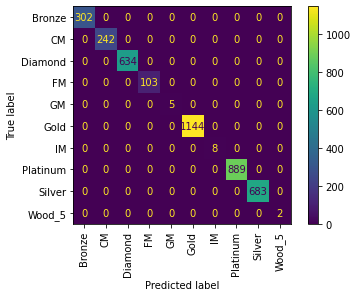

In [177]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_boost, X_val, y_val, values_format='.0f', xticks_rotation='vertical');


In [178]:
info.head()


,White Wins,Black Wins,Draw,TGP
opening_eco,,,,
A00,398,570,39,1007
C00,417,389,38,844
D00,341,360,38,739
B01,358,332,26,716
C41,396,267,28,691


In [179]:
ranking.head()

,turns,winner,increment_code,white_rating,black_rating,opening_eco,White Wins,Black Wins,Draw,ranking,Disparity
0,13,white,15+2,1500,1191,D10,1,0,0,Gold,309
1,16,black,5+10,1322,1261,B00,0,1,0,Silver,61
2,61,white,5+10,1496,1500,C20,1,0,0,Gold,4
3,61,white,20+0,1439,1454,D02,1,0,0,Gold,15
4,95,white,30+3,1523,1469,C41,1,0,0,Gold,54


In [180]:
increment = df2.groupby(['increment_code']).sum()
increment = increment.drop(columns=['white_rating', 'black_rating', 'turns'])
increment['TGP'] = increment['White Wins'] + increment['Black Wins'] + increment['Draw']
increment = increment.sort_values(by=['TGP'], ascending=False)
increment = increment.copy()
increment['White Wins'] = increment['White Wins'] / increment['TGP']
increment['Black Wins'] = increment['Black Wins'] / increment['TGP']
increment['Draw'] = increment['Draw'] / increment['TGP']

increment.head(10)

,White Wins,Black Wins,Draw,TGP
increment_code,,,,
10+0,0.497863,0.461210,0.040927,7721
15+0,0.500381,0.459954,0.039664,1311
15+15,0.490588,0.463529,0.045882,850
5+5,0.513550,0.447154,0.039295,738
5+8,0.496413,0.469154,0.034433,697
8+0,0.500000,0.442177,0.057823,588
10+5,0.492228,0.471503,0.036269,579
15+10,0.509761,0.412148,0.078091,461
20+0,0.497768,0.459821,0.042411,448


Based off of the data provided, 10 min games with 0 delay are far and away the most popular. 15+10 have the highest draw rate, and 5+5 is the highest win rate for White, presumably because the less time available, the more powerful the first move advantage is. Given more time I would try to dissect that a little more, and see if thre is a specific opening that leads to that disparity. 